Datasets:

cases and deaths by country and state.

Datasets wanted:

- location data
- testing by country and state
- population age structure? 
- lockdowns (and other interventions) by country and state

Plot ideas:

- plot rank change to see which ones are trending worse and which are trending better
- plot dpm change / dpm to plot the growth rate (slope) over time
- plt dpm change to plot the rate * base - base, which relates to hospital capacity.


In [108]:
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import time
import timeit

%matplotlib inline

## Data Sources

In [204]:
DATA_DIR = Path('data')

# For quick tests
# df = pd.read_csv('data/us-states.csv').rename(columns={'state': 'entity'})

def load_owid_country_data(download=True, cache=False):
    # country covid data
    url = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
    filename = DATA_DIR / 'full_data.csv' # cached version
    if download:
        df = pd.read_csv(url)
        if cache:
            df.to_csv(filename)
    else:
        df = pd.read_csv(filename)
    
    df = df.rename(columns={'total_cases': 'cases', 
                                          'total_deaths': 'deaths',
                                          'location': 'entity'})
    df['date'] = pd.to_datetime(df['date'])

    # Adding country population data...
    # map UN country names to OWID country names
    u2o = dict([
         ('Bolivia (Plurinational State of)', 'Bolivia'),
         ('Brunei Darussalam', 'Brunei'),
         ('Cabo Verde', 'Cape Verde'),
         ("Côte d'Ivoire", "Cote d'Ivoire"),
         ('Curaçao', 'Curacao'),
         ('Czechia', 'Czech Republic'),
         ('Democratic Republic of the Congo', 'Democratic Republic of Congo'),
         ('Faroe Islands', 'Faeroe Islands'),
         ('Falkland Islands (Malvinas)', 'Falkland Islands'),
         ('Iran (Islamic Republic of)', 'Iran'),
         ("Lao People's Democratic Republic", 'Laos'),
         ('North Macedonia', 'Macedonia'),
         ('Northern Mariana Islands', 'Mariana Islands'),
         ('Republic of Moldova', 'Moldova'),
         ('State of Palestine', 'Palestine'),
         ('Russian Federation', 'Russia'),
         ('Republic of Korea', 'South Korea'),
         ('Eswatini', 'Swaziland'),
         ('Syrian Arab Republic', 'Syria'),
         ('China, Taiwan Province of China', 'Taiwan'),
         ('United Republic of Tanzania', 'Tanzania'),
         ('Timor-Leste', 'Timor'),
         ('United States of America', 'United States'),
         ('Holy See', 'Vatican'),
         ('Venezuela (Bolivarian Republic of)', 'Venezuela'),
         ('Viet Nam', 'Vietnam')
    ])
    # Load UN population data
    pop_df = pd.read_csv(DATA_DIR / 'WPP2019_TotalPopulationBySex.csv')
    # Use the medium variant projection for the year 2020 of total population
    pop_df = pop_df.loc[(pop_df['Time'] == 2020) & (pop_df['Variant'] == 'Medium'), ['Location', 'PopTotal']]
    # Convert Locations to match OWID country names
    pop_df['Location'] = pop_df['Location'].apply(lambda l: l if l not in u2o else u2o[l])
    pop_df['PopTotal'] = pop_df['PopTotal'] * 1000
#     display(df.head())
#     display(pop_df.head())
    df = (df.merge(pop_df, how='inner', left_on='entity', right_on='Location')
          .drop(columns='Location').rename(columns={'PopTotal': 'population'}))
    df['deaths_per_million'] = df['deaths'] / df['population'] * 1e6
    df['cases_per_million'] = df['cases'] / df['population'] * 1e6
    df['new_deaths_per_million'] = df['new_deaths'] / df['population'] * 1e6
    df['new_cases_per_million'] = df['new_cases'] / df['population'] * 1e6
#     display(df.head())
    
    return df


# def load_owid_deaths_per_million_since(from_days=None, filter_na=True, dataset_date='20200331'):
#     '''
#     Our World In Data deaths per million country dataset.
#     Contains deaths_per_million and days since >= 0.1 / million for countries and world.
#     dataset_date: '20200330' or '20200331'. Which file to use. The date corresponds 
#     to when the file was downloaded.
#     '''
#     if dataset_date == '20200330':
#         DAYS_COL = 'Days since total confirmed COVID-19 deaths reached 0.1 per million'
#         DPM_COL = 'Total confirmed deaths due to COVID-19 per million (deaths per million)'
#     elif dataset_date == '20200331':
#         DAYS_COL = 'Days since total confirmed deaths reached 0.1 per million (days)'
#         DPM_COL = 'Total confirmed deaths per million (deaths per million)'
        
#     # A table containing entity (countries mostly), date, days since 0.1 per million, deaths per million.
#     df = pd.read_csv(DATA_DIR / f'{dataset_date}-OWID-covid-deaths-days-since-per-million.csv')
#     df['Date'] = pd.to_datetime(df['Date'])  # convert date string

#     # filter dates for most recent 30 days, b/c data is really sparse before that
#     if from_days is not None:
#         from_date = df['Date'].max() - datetime.timedelta(days=from_days)
#         df = df.loc[df['Date'] > from_date]
        
#     # filter observations with NaN days since 0.1 per million
#     # to reduce the sparsity of the data and to fix pivot issues
#     # filter the 6 rows with nan deaths per million.
#     df = (df.loc[(df[DAYS_COL].notna()) & (df[DPM_COL].notna()), :]
#           .rename(columns={DAYS_COL: 'days_since', 
#                            DPM_COL: 'deaths_per_million',
#                            'Date': 'date',
#                            'Entity': 'entity'})
#          )
    
#     # filter observations from the current (dataset) day, b/c they might be incomplete.
#     df = df.loc[df['date'] < pd.to_datetime(dataset_date)]
    
#     return df


def load_nytimes_us_state_data(download=True, cache=False):
    '''
    nytimes dataset with cases and deaths (cummulative) for US states.
    '''
    url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
    filename = DATA_DIR / 'us-states.csv'
    if download:
        df = pd.read_csv(url)
        if cache:
            df.to_csv(filename)
    else:
        df = pd.read_csv(filename)
    
    df = df.rename(columns={'state': 'entity'})
    df['date'] = pd.to_datetime(df['date'])
    
    # Add state population, used to get deaths per million
    pop_df = (pd.read_csv(DATA_DIR / 'nst-est2019-alldata.csv')
              .loc[lambda d: d['SUMLEV'] == 40, ]
             )
    df = (df.merge(pop_df, how='inner', left_on='entity', right_on='NAME')
           .loc[:, ['date', 'entity', 'cases', 'deaths', 'POPESTIMATE2019']]
           .rename(columns={'POPESTIMATE2019': 'population'})
          )
    
    # Add daily change
    grouped = df.groupby(['entity'])
    df['new_cases'] = grouped['cases'].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[1] - w.iloc[0]))
    df['new_deaths'] = grouped['deaths'].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[1] - w.iloc[0]))
    df['cases_daily_growth_rate'] = grouped['cases'].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[1] / w.iloc[0]))
    df['deaths_daily_growth_rate'] = grouped['deaths'].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[1] / w.iloc[0]))
    
    df['deaths_per_million'] = df['deaths'] / df['population'] * 1e6
    df['cases_per_million'] = df['cases'] / df['population'] * 1e6
    df['new_deaths_per_million'] = df['new_deaths'] / df['population'] * 1e6
    df['new_cases_per_million'] = df['new_cases'] / df['population'] * 1e6
#     mer = mer.loc[mer['deaths_per_million'] >= 0.1, :]  # ignore anything smaller than 0.1 DPM
#     days_since = mer.groupby(['entity'])['deaths_per_million'].transform(lambda s: list(range(len(s))))
#     mer = mer.assign(days_since=days_since)
    return df
   

def make_nday_ratio(df, col, n=1):
    return df.groupby(['entity'])[col].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] / w.iloc[0]))
    
    
def make_nday_diff(df, col, n=1):
    return df.groupby(['entity'])[col].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] - w.iloc[0]))
    

def before_threshold(df, col, thresh):
    '''
    Return boolean index of df rows before the first day when the threshold
    was met, i.e. when df[col] >= thresh. This is done with each entity.
    :param df: entity/state/country column, ordered by date column, cases, deaths, etc.
    '''
    return df.groupby(['entity'])[col].transform(lambda s: (s >= thresh).cumsum() == 0)


def fill_before_first(df, col, thresh, thresh_col=None, fill=np.nan):
    '''
    Within each entity, df[col] = fill when df[thresh_col] < thresh 
    and occur before the first day that df[thresh_col] >= threshold.
    :param col: the column to fill
    :param thresh_col: if not None, use this column to determine which rows
    '''
    return df[col].where(~before_threshold(df, thresh_col, thresh),
                         np.nan)


def make_days_since(df, col, thresh):
    '''
    Days since first day the value of col >= thresh. 
    Example of column and threshold from data journalists:
    - days since deaths per million reached 0.1 deaths per million
      (OWID deaths per million trajectories).
    - days since 3 daily deaths first recorded (FT daily deaths trajectory)
      https://twitter.com/jburnmurdoch/status/1245466020053164034
      
    Example usage:
        df['days_since'] = make_days_since(df, 'deaths_per_million', 0.1)
    '''
    # >>> a = np.array([[1,1,1,1],[1,2,1,2],[1,1,2,2],[2,2,2,2]]).astype(float)
    # >>> a
    # array([[1., 1., 1., 1.],
    #        [1., 2., 1., 2.],
    #        [1., 1., 2., 2.],
    #        [2., 2., 2., 2.]])
    # >>> b = ((a > 1).cumsum(axis=1) > 0).cumsum(axis=1).astype(float) - 1
    # >>> b[b < 0] = np.nan
    # >>> b
    # array([[nan, nan, nan, nan],
    #        [nan,  0.,  1.,  2.],
    #        [nan, nan,  0.,  1.],
    #        [ 0.,  1.,  2.,  3.]])
    def days_since(s, thresh):
        '''s: a Series containing the values of col for an entity ordered by date'''
        days = ((s >= thresh).cumsum() > 0).cumsum().astype(float) - 1
        days[days < 0] = np.nan
        return days
        
    return df.groupby(['entity'])[col].transform(days_since, thresh=thresh)


def add_derived_values_cols(df, values):
    '''
    deaths_per_million
    deaths_per_day
    deaths_per_day_7day_avg
    deaths_per_week
    deaths_per_million_per_day
    deaths_per_million_per_day_7day_avg
    deaths_per_million_per_week
    deaths_ratio_per_day
    deaths_ratio_per_day_7day_avg
    deaths_ratio_per_week
    '''
    values_per_million = values + '_per_million'
    df[values_per_million] = df[values] / df['population'] * 1e6

    values_per_day = values + '_per_day'
    df[values_per_day] = df.groupby(['entity'])[values].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] - w.iloc[0]))

    # FT: 7-day rolling average of daily change in deaths
    # https://www.ft.com/coronavirus-latest
    values_per_day_7day_avg = values_per_day + '_7day_avg'
    df[values_per_day_7day_avg] = (df.groupby(['entity'])[values_per_day]
                                               .transform(lambda s: s.rolling(7).mean()))                                   

    values_per_week = values + '_per_week'
    df[values_per_week] = df.groupby(['entity'])[values].transform(
        lambda s: s.rolling(8).apply(lambda w: w.iloc[-1] - w.iloc[0]))

    values_per_million_per_day = values_per_million + '_per_day'
    df[values_per_million_per_day] = df.groupby(['entity'])[values_per_million].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] - w.iloc[0]))

    # Per capita alternative to unnormalized FT values
    values_per_million_per_day_7day_avg = values_per_million_per_day + '_7day_avg'
    df[values_per_million_per_day_7day_avg] = (df.groupby(['entity'])[values_per_million_per_day]
                                               .transform(lambda s: s.rolling(7).mean()))                                   

    values_per_million_per_week = values_per_million + '_per_week'
    df[values_per_million_per_week] = df.groupby(['entity'])[values_per_million].transform(
        lambda s: s.rolling(8).apply(lambda w: w.iloc[-1] - w.iloc[0]))

    values_ratio_per_day = values + '_ratio_per_day'
    df[values_ratio_per_day] = df.groupby(['entity'])[values].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] / w.iloc[0]))

    values_ratio_per_day_7day_avg = values_ratio_per_day + '_7day_avg'
    df[values_ratio_per_day_7day_avg] = (df.groupby(['entity'])[values_ratio_per_day]
                                               .transform(lambda s: s.rolling(7).mean()))                                   
    
    values_ratio_per_week = values + '_ratio_per_week'
    df[values_ratio_per_week] = df.groupby(['entity'])[values].transform(
        lambda s: s.rolling(8).apply(lambda w: w.iloc[-1] / w.iloc[0]))
    
    return df



#### Figure out how to map UN Locations to OWID Entities

In [149]:
def map_owid_to_un_pop(mer=None):
    '''
    Print where owid countries and un countries do not line up.
    Visually inspect to build a mapping so that all OWID countries map.
    '''
    # convert UN country names to OWID country names.
    # 'Guernsey': None,  # No population info in UN csv.
    # 'International': None,  # Not a country. :-)
    # 'Jersey': None, # Guernsey and Jersey are british channel islands
    # 'Kosovo': None, # Republic of Kosovo
    u2o = dict([
         ('Bolivia (Plurinational State of)', 'Bolivia'),
         ('Brunei Darussalam', 'Brunei'),
         ('Cabo Verde', 'Cape Verde'),
         ("Côte d'Ivoire", "Cote d'Ivoire"),
         ('Curaçao', 'Curacao'),
         ('Czechia', 'Czech Republic'),
         ('Democratic Republic of the Congo', 'Democratic Republic of Congo'),
         ('Faroe Islands', 'Faeroe Islands'),
         ('Falkland Islands (Malvinas)', 'Falkland Islands'),
         ('Iran (Islamic Republic of)', 'Iran'),
         ("Lao People's Democratic Republic", 'Laos'),
         ('North Macedonia', 'Macedonia'),
         ('Northern Mariana Islands', 'Mariana Islands'),
         ('Republic of Moldova', 'Moldova'),
         ('State of Palestine', 'Palestine'),
         ('Russian Federation', 'Russia'),
         ('Republic of Korea', 'South Korea'),
         ('Eswatini', 'Swaziland'),
         ('Syrian Arab Republic', 'Syria'),
         ('China, Taiwan Province of China', 'Taiwan'),
         ('United Republic of Tanzania', 'Tanzania'),
         ('Timor-Leste', 'Timor'),
         ('United States of America', 'United States'),
         ('Holy See', 'Vatican'),
         ('Venezuela (Bolivarian Republic of)', 'Venezuela'),
         ('Viet Nam', 'Vietnam')
    ])

    if mer is None:
        pop_df = pd.read_csv(DATA_DIR / 'WPP2019_TotalPopulationBySex.csv')
        # Convert Locations to match OWID country names
        pop_df['Location'] = pop_df['Location'].apply(lambda l: l if l not in u2o else u2o[l])
        # Use the medium variant projection for the year 2020 of total population
        pop_df = pop_df.loc[(pop_df['Time'] == 2020) & (pop_df['Variant'] == 'Medium'), ['Location', 'PopTotal']]
        df = load_owid_country_data(download=True, cache=False)
        mer = df.merge(pop_df, how='outer', left_on='entity', right_on='Location')
    
    
    print('OWID entity not found in UN pop Location')
    print(mer.loc[mer['Location'].isna(), 'entity'].unique())
    print('UN pop Location not found in OWID entity')
    print(mer.loc[mer['entity'].isna(), 'Location'].unique())
    return mer

# mer = map_owid_to_un_pop()
# mer

In [170]:
# load data
# df['days_since'] = make_days_since(df, 'deaths_per_million', 0.1)
download = False
states_df = load_nytimes_us_state_data(download=download, cache=True)
countries_df = load_owid_country_data(download=download, cache=True)
display(states_df.sample(10))
display(countries_df.sample(10))
# combine countries and states, dropping the countries 'Puerto Rico' (b/c it is in states_df) and 'Georgia' (b/c a state is named 'Georgia')
all_df = (countries_df.loc[~countries_df['entity'].isin(['Georgia', 'Puerto Rico']), ['date', 'entity', 'cases', 'deaths', 'population']]
          .append(states_df.loc[:, ['date', 'entity', 'cases', 'deaths', 'population']], ignore_index=True)
          .reset_index(drop=True))
print(states_df.shape, countries_df.shape, all_df.shape)
display(all_df.sample(10))


,date,entity,cases,deaths,population,new_cases,new_deaths,cases_daily_growth_rate,deaths_daily_growth_rate,deaths_per_million,cases_per_million,new_deaths_per_million,new_cases_per_million
1291,2020-03-18,Missouri,21,1,6137428,5.0,1.0,1.312500,inf,0.162935,3.421629,0.162935,0.814674
107,2020-02-23,Illinois,2,0,12671821,0.0,0.0,1.000000,NaN,0.000000,0.157831,0.000000,0.000000
15,2020-02-05,Washington,1,0,7614893,0.0,0.0,1.000000,NaN,0.000000,0.131322,0.000000,0.000000
1109,2020-03-25,Minnesota,287,1,5639632,25.0,0.0,1.095420,1.000000,0.177317,50.889845,0.000000,4.432913
583,2020-03-11,Oregon,20,0,4217737,6.0,0.0,1.428571,NaN,0.000000,4.741879,0.000000,1.422564
62,2020-03-23,Washington,2101,110,7614893,257.0,13.0,1.139371,1.134021,14.445377,275.906700,1.707181,33.749653
531,2020-02-27,Utah,1,0,3205958,0.0,0.0,1.000000,NaN,0.000000,0.311919,0.000000,0.000000
267,2020-03-09,Arizona,6,0,7278717,1.0,0.0,1.200000,NaN,0.000000,0.824321,0.000000,0.137387
871,2020-03-14,Colorado,103,2,5758736,25.0,0.0,1.320513,1.000000,0.347298,17.885869,0.000000,4.341230
1347,2020-03-12,Virginia,17,0,8535519,7.0,0.0,1.700000,NaN,0.000000,1.991677,0.000000,0.820102


,Unnamed: 0,date,entity,new_cases,new_deaths,cases,deaths,population,deaths_per_million,cases_per_million,new_deaths_per_million,new_cases_per_million
7378,7522,2020-04-06,Saint Vincent and the Grenadines,0,0,7,0,1.109470e+05,0.000000,63.093189,0.000000,0.000000
660,660,2020-01-26,Azerbaijan,0,0,0,0,1.013918e+07,0.000000,0.000000,0.000000,0.000000
2223,2230,2020-03-12,Czech Republic,31,0,94,0,1.070898e+07,0.000000,8.777678,0.000000,2.894766
5221,5356,2020-02-02,Luxembourg,0,0,0,0,6.259760e+05,0.000000,0.000000,0.000000,0.000000
3089,3096,2020-03-06,France,138,3,423,7,6.527351e+07,0.107241,6.480423,0.045960,2.114181
3488,3495,2020-02-22,Greece,0,0,0,0,1.042306e+07,0.000000,0.000000,0.000000,0.000000
4001,4028,2020-02-12,Indonesia,0,0,0,0,2.735236e+08,0.000000,0.000000,0.000000,0.000000
8389,8533,2020-03-22,Switzerland,1237,13,6077,56,8.654618e+06,6.470534,702.168484,1.502088,142.929474
9357,9501,2020-01-28,World,1767,25,4587,106,7.794799e+09,0.013599,0.588469,0.003207,0.226690
2819,2826,2020-02-26,Estonia,0,0,0,0,1.326539e+06,0.000000,0.000000,0.000000,0.000000


(1882, 13) (9469, 12) (11242, 5)


,date,entity,cases,deaths,population
156,2020-02-04,Algeria,0,0,4.385104e+07
1787,2020-01-13,China,59,1,1.439324e+09
2355,2020-03-17,Denmark,932,1,5.792203e+06
7902,2020-03-06,Spain,261,3,4.675478e+07
9575,2020-03-29,California,6266,130,3.951222e+07
10601,2020-03-30,District of Columbia,495,9,7.057490e+05
8641,2020-03-24,Turkey,1529,37,8.433907e+07
8653,2020-04-05,Turkey,23934,501,8.433907e+07
7189,2020-04-06,Russia,5389,45,1.459345e+08
3919,2020-02-27,Indonesia,0,0,2.735236e+08


## Plot Vermont Coronavirus Cases vs Date

In [171]:
list(states_df.loc[(states_df['population'] < 5e6) & (states_df['population'] > 3e6), :].groupby('entity').first().sort_values(by='population').index)
set(states_df['entity']).intersection(countries_df['entity'])



{'Georgia', 'Puerto Rico'}

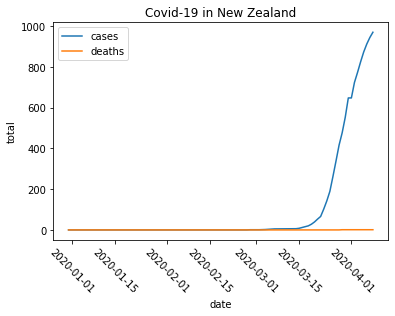

,Unnamed: 0,date,entity,new_cases,new_deaths,cases,deaths,population,deaths_per_million,cases_per_million,new_deaths_per_million,new_cases_per_million
6256,6391,2020-03-21,New Zealand,14,0,53,0,4822233.0,0.000000,10.990759,0.000000,2.903219
6257,6392,2020-03-22,New Zealand,13,0,66,0,4822233.0,0.000000,13.686605,0.000000,2.695847
6258,6393,2020-03-23,New Zealand,36,0,102,0,4822233.0,0.000000,21.152026,0.000000,7.465421
6259,6394,2020-03-24,New Zealand,40,0,142,0,4822233.0,0.000000,29.446939,0.000000,8.294912
6260,6395,2020-03-25,New Zealand,47,0,189,0,4822233.0,0.000000,39.193461,0.000000,9.746522
6261,6396,2020-03-26,New Zealand,73,0,262,0,4822233.0,0.000000,54.331676,0.000000,15.138215
6262,6397,2020-03-27,New Zealand,76,0,338,0,4822233.0,0.000000,70.092009,0.000000,15.760333
6263,6398,2020-03-28,New Zealand,78,0,416,0,4822233.0,0.000000,86.267088,0.000000,16.175079
6264,6399,2020-03-29,New Zealand,60,1,476,1,4822233.0,0.207373,98.709457,0.207373,12.442369
6265,6400,2020-03-30,New Zealand,76,0,552,1,4822233.0,0.207373,114.469790,0.000000,15.760333


In [187]:
df = countries_df
entity = 'New Zealand'
# df = states_df
# entity = 'Vermont'
df = df.loc[df['entity'] == entity, :]
for var in ['cases', 'deaths']:
    plt.plot(df['date'], df[var], label=var)
#     plt.semilogy(df['date'], df[var], label=var)
    
plt.xticks(rotation=-45)
plt.ylabel('total')
plt.xlabel('date')
plt.title(f'Covid-19 in {entity}')
plt.legend()
plt.show()
df.loc[df['date'] > pd.to_datetime('2020-03-20')]

## Trajectory Plots for deaths or deaths per million vs Date or Days Since

An excellent example of a similar plot of log(DPM) vs days since 0.1 DPM is https://ourworldindata.org/grapher/covid-deaths-days-since-per-million. It visually shows which countries are on similar trajectories, but makes it hard to compare the timeline of when interventions in countries are happening and what their outbreak looked like when those interventions were put in place.

Plotting log(DPM) vs date makes it harder to see the similarities of trajectories (though many of the trajectories look similar. Harder to plot those awesome sloped lines that say "doubles every 2 days", "doubles every 3 days", "doubles every 5 days", etc. Maybe an inset protractor-like graphic showing the doubling times.


### Hospital Beds

What is the medical capacity required to handle the peak of the infection. It depends on how full the beds are, at what rate new patients are coming in, and what rate old patients are leaving (death or recovery).

When plotted on a log(deaths per million) scale, what "slope" can a given amount of medical capacity (ICU beds, ventilators, healthcare workers, PPE, etc.) handle? Assume that the daily change in deaths per million is proportional (accounting for lag and growth changes) to incoming icu cases. For a steady state between incoming ICU cases and outgoing ICU cases (death and recovery), outgoing ICU cases (deaths and recoveries) must equal incoming ICU cases and therefore be proportional to delta deaths per million. And delta deaths per million relates deaths per million * slope. 

Why should we care? As deaths per million goes up, the slope must decrease to match hospital capacity. That means the government response must be stronger and more burdensome.
 
If delta_dpm exceeds this amount, than the number of incoming patients exceeds outgoing and must be absorbed by  available medical capacity. If delta_dpm is less than this amount, the number of incoming patients is less than the number of outgoing patients, and available hospital capacity increases.

In [223]:
# Seasonal Flu Death Source
# https://www.cdc.gov/flu/about/burden/index.html
# seasons: 2010-2011, 2011-2012, 2012-2013, 2013-2014, 2014-2015, 2015-2016, 2016-2017, 2017-2018
seasonal_flu_deaths = np.array([37000, 12000, 43000, 38000, 51000, 23000, 38000, 61000])
# US Population Source
# https://www.worldometers.info/world-population/us-population/
us_pop = 331000000 # estimated 2020 population
seasonal_flu_dpm = seasonal_flu_deaths.mean() / us_pop * 1e6
bad_flu_dpm = seasonal_flu_deaths.max() / us_pop * 1e6
print(f'seasonal_flu_dpm: {seasonal_flu_dpm}, bad_flu_dpm: {bad_flu_dpm}')


def plot_trajectories(df, index_col='date', values_col='deaths', rank=False, n_top=None,
                      includes=None, excludes=None, n_show=None):
    '''
    df: columns: date, deaths, cases, population
    index_col: either date or days_since. This is the pivot index.
    values_col: e.g. deaths, deaths_per_million, deaths_per_day, deaths_per_million_per_day
    rank: plot the ranks of the values within each day.
    n_top: int > 0. Display the n highest trajectories on the chart.
    n_show: int > 0. Show at most n on the chart.
    includes: array of entities to highlight.
    excludes: array of entities to exclude from chart.
    '''
    
    # https://stackoverflow.com/questions/13851535/delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression-involving
    if excludes:
        df = df.loc[~df['entity'].isin(excludes), :]
        
    # remove obsevations without values
    df = df.loc[df[values_col].notna(), :] 
    # remove observations without index value 
    # for example, days that happen before the first day of the days_since column
    df = df.loc[df[index_col].notna(), :]

    # Pivot to a table with country/entity columns and date/days_since rows
    piv = df.pivot(index=index_col, columns='entity', values=values_col)
    piv = piv.loc[piv.notnull().any(axis=1), :]  # remove rows with all null values

    # entities ranked by each day, or by each day since 0.1.
    if rank:
        piv = piv.rank(axis=1, method='average', ascending=False)
  
    # Plot countries in order, sorting by the most recent value for each entity.
    # For days_since, the last value can be nan. Find the most recent non-nan value.
    sort_idx = np.argsort(piv.apply(lambda s: s[s.notna()].iloc[-1], axis=0))
    if not rank:
        # plot deaths per million from largest to smallest
        sort_idx = sort_idx[::-1]
    
    # Choose which entitites to plot
    sorted_entities = piv.columns.values[sort_idx]
#     print('Num sorted_entities:', len(sorted_entities))
    n_ent = len(sorted_entities) 
    n_top = n_ent if n_top is None else n_top
    n_show = n_ent if n_show is None else n_show
    includes_idx = np.isin(sorted_entities, includes) if includes else np.zeros_like(sorted_entities, dtype=bool)
    excludes_idx = np.isin(sorted_entities, excludes) if excludes else np.zeros_like(sorted_entities, dtype=bool)
    priority_idx = np.hstack([np.arange(n_ent)[includes_idx & ~excludes_idx],
                              np.arange(n_ent)[~includes_idx & ~excludes_idx]])
    show_entities = sorted_entities[np.sort(priority_idx[:n_show])]
    top_entities = sorted_entities[np.sort(priority_idx[:n_top])]
    print(len(show_entities), show_entities)
    # Figure
    fig, ax = plt.subplots(figsize=(16,8))
    for i, entity in enumerate(show_entities):
        if entity in top_entities:
            linewidth = 2.0
            alpha = 1.0
            entity_rank = np.arange(n_ent)[sorted_entities == entity][0] + 1
            label = f'{entity}[{entity_rank}]'
            annotation = entity
            last_idx = piv.index[piv[entity].notna()].values[-1]
        else:
            linewidth = 1.0
            alpha = 0.5
            label = None
            annotation = None
            
        if rank or 'ratio' in values_col:
            plt.plot(piv.index, piv[entity], label=label, linewidth=linewidth, alpha=alpha)
        else:
            plt.semilogy(piv.index, piv[entity], label=label, linewidth=linewidth, alpha=alpha,
                         marker='o', markersize='4')
            if annotation:
                plt.annotate(entity, xy=(last_idx, piv[entity].loc[last_idx]))
            

    # pivot == 'days_since' maybe does not play well with bad_flu in the data.
    if values_col == 'deaths_per_million' and not rank:
        plt.axhline(seasonal_flu_dpm, color='blue', linestyle='--', label='seasonal flu')
        plt.axhline(bad_flu_dpm, color='orange', linestyle='--', label='bad flu')
        
    if rank:
        ax.invert_yaxis()
        
    ylabel = values_col
    if rank:
        ylabel += ' (rank)'
    else:
        ylabel += ' (log scale)'
    plt.ylabel(ylabel)
    
    if index_col == 'date':
        plt.xlabel('Date')
    elif index_col == 'days_since':
        plt.xlabel(f'Days since outbreak began')
      
    title = f'{values_col}{"" if not rank else " (rank)"} in Each Location' 
    title += ' Over Time' if index_col != 'days_since' else f' Since Outbreak Began'
    plt.title(title)
    
    plt.xticks(rotation=-60)
    plt.legend()
    plt.show()
    return piv




seasonal_flu_dpm: 114.42598187311178, bad_flu_dpm: 184.29003021148037


10 ['New York' 'Luxembourg' 'Iceland' 'New Jersey' 'Louisiana' 'Spain'
 'Switzerland' 'Italy' 'New Zealand' 'Minnesota']


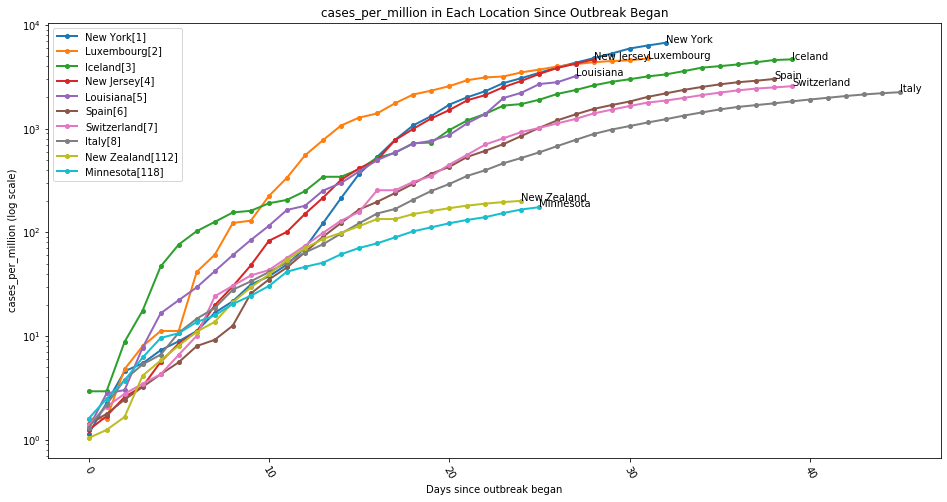

In [236]:
# lockdowns:
# Minnesota - stay-at-home 3/27 https://www.mprnews.org/story/2020/03/25/latest-on-covid19-in-minnesota
# New Zealand - lockdown 3/25 https://www.washingtonpost.com/world/asia_pacific/new-zealand-isnt-just-flattening-the-curve-its-squashing-it/2020/04/07/6cab3a4a-7822-11ea-a311-adb1344719a9_story.html

# df = states_df
# df = countries_df
df = all_df
# df = add_derived_values_cols(df, 'deaths')
df = add_derived_values_cols(df, 'cases')

# index_col, thresh, values_col = ('days_since', 0.1, 'deaths_per_million')
# index_col, thresh, values_col = ('days_since', 1.0, 'deaths_per_million')
# index_col, thresh, values_col = ('days_since', 3, 'deaths_per_day')
# index_col, thresh, values_col = ('days_since', 20, 'deaths_per_week')
# index_col, thresh, values_col = ('date', 0.1, 'deaths_per_million')
# index_col, thresh, values_col = ('date', 1.1, 'deaths_ratio_per_week')
# index_col, thresh, values_col = ('days_since', 1.1, 'deaths_ratio_per_week')

index_col = 'days_since'
# index_col = 'date'

# values_col = 'deaths_ratio_per_day_7day_avg'
# values_col = 'deaths_per_million'
# values_col = 'deaths_per_day_7day_avg'
# values_col = 'deaths_per_million_per_day_7day_avg'
values_col = 'cases_per_million'
# values_col = 'cases_per_million_per_day_7day_avg'

n_top = 10
n_show = n_top
rank = False
# rank = True

# FT threshold condition https://www.ft.com/coronavirus-latest 2020-03-02
# days_since_col = 'deaths_per_day'; days_since_thresh = 3.0
# FT thesh: number of days since 30 daily cases first recorded
# days_since_col = 'cases_per_day'; days_since_thresh = 30
# OWID threshold condition https://ourworldindata.org/grapher/covid-deaths-days-since-per-million
# days_since_col = 'deaths_per_million'; days_since_thresh = 0.1
days_since_col = 'cases_per_million'; days_since_thresh = 1

# Trim rows before the timeperiod we are looking at:
if days_since_col:
    df[values_col] = fill_before_first(df, values_col, days_since_thresh, thresh_col=days_since_col)
    if index_col == 'days_since':
        df['days_since'] = make_days_since(df, days_since_col, days_since_thresh)

includes = [
#     'United States', 'Italy', 'Sweden', 'Spain', 'France',
#             'Vermont', 'California', 'Washington', 'New York', 'Michigan', 'Louisiana', 'Massachusetts'
#             'China',
            'New Zealand',
           ]
# includes += ['Arkansas', 'Nevada', 'Iowa', 'Puerto Rico', 'Utah', 'Connecticut', 'Oklahoma', 'Oregon',
#              'Kentucky', 'Louisiana', 'Alabama']
includes += [
#     'New Mexico', 'Kansas', 'Mississippi', 'Arkansas', 'Nevada', 
#              'Iowa', 'Puerto Rico', 'Utah', 'Connecticut', 'Oklahoma',
#              'Oregon', 'Kentucky', 'Louisiana', 'Alabama', 'South Carolina',
             'Minnesota',
#              'Colorado', 'Wisconsin',
            ]
# excludes = ['World', 'San Marino', 'Andorra', 'China']
excludes = ['World', 'San Marino', 'Andorra', 'Sint Maarten (Dutch part)',
            'Vatican', 'Faeroe Islands', 'Gibraltar']
piv = plot_trajectories(df, index_col=index_col, values_col=values_col, 
                        rank=rank, n_top=n_top, n_show=n_show,
                        includes=includes, excludes=excludes)


In [229]:
df[df['entity'] == 'Minnesota']

,date,entity,cases,deaths,population,deaths_per_million,deaths_per_day,deaths_per_day_7day_avg,deaths_per_week,deaths_per_million_per_day,...,cases_per_day,cases_per_day_7day_avg,cases_per_week,cases_per_million_per_day,cases_per_million_per_day_7day_avg,cases_per_million_per_week,cases_ratio_per_day,cases_ratio_per_day_7day_avg,cases_ratio_per_week,days_since
10450,2020-03-06,Minnesota,1,0,5639632.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10451,2020-03-07,Minnesota,1,0,5639632.0,NaN,0.0,NaN,NaN,0.000000,...,0.0,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN
10452,2020-03-08,Minnesota,2,0,5639632.0,NaN,0.0,NaN,NaN,0.000000,...,1.0,NaN,NaN,0.177317,NaN,NaN,2.000000,NaN,NaN,NaN
10453,2020-03-09,Minnesota,2,0,5639632.0,NaN,0.0,NaN,NaN,0.000000,...,0.0,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN
10454,2020-03-10,Minnesota,3,0,5639632.0,NaN,0.0,NaN,NaN,0.000000,...,1.0,NaN,NaN,0.177317,NaN,NaN,1.500000,NaN,NaN,NaN
10455,2020-03-11,Minnesota,5,0,5639632.0,NaN,0.0,NaN,NaN,0.000000,...,2.0,NaN,NaN,0.354633,NaN,NaN,1.666667,NaN,NaN,NaN
10456,2020-03-12,Minnesota,9,0,5639632.0,NaN,0.0,NaN,NaN,0.000000,...,4.0,NaN,NaN,0.709266,NaN,NaN,1.800000,NaN,NaN,0.0
10457,2020-03-13,Minnesota,14,0,5639632.0,NaN,0.0,0.000000,0.0,0.000000,...,5.0,1.857143,13.0,0.886583,0.329302,2.305115,1.555556,1.503175,14.000000,1.0
10458,2020-03-14,Minnesota,21,0,5639632.0,NaN,0.0,0.000000,0.0,0.000000,...,7.0,2.857143,20.0,1.241216,0.506619,3.546331,1.500000,1.574603,21.000000,2.0
10459,2020-03-15,Minnesota,35,0,5639632.0,NaN,0.0,0.000000,0.0,0.000000,...,14.0,4.714286,33.0,2.482431,0.835921,5.851446,1.666667,1.526984,17.500000,3.0
